---
---
# Strategic Growth Analysis
---
---
## Comprehensive Business Intelligence for Unique Gifts Ltd.

**Project Overview:**
This notebook contains a comprehensive analysis of transactional data from Unique Gifts Ltd., a UK-based online retailer. The analysis follows a structured approach to provide data-driven strategic insights and recommendations.

**Business Objectives:**
1. Sales Performance & Seasonality Analysis
2. Product Portfolio Optimization
3. Geographic Market Analysis
4. Customer Segmentation using RFM Analysis
5. Wholesaler vs. Retail Customer Analysis
6. Data Enrichment via API Integration

---

## Setup and Data Loading

In [1]:

# Import required libraries
import sys
import os

# Add the src directory to Python path
sys.path.append('../src')

# Import modules
import data_cleaning as dc
from eda_analysis import *
from rfm_segmentation import run_complete_analysis, generate_visualizations, export_results_phase_3
from api_integration import *

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# Set Seaborn styling
sns.set(style='whitegrid', palette='pastel')
# Set display options
pd.set_option('display.max_columns', None) # Display all columns of the DataFrame without truncation
pd.set_option('display.max_rows', 100) # Display a maximum of 100 rows in the DataFrame

print("📦 All libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📦 All libraries imported successfully!
📅 Analysis Date: 2025-08-26 10:01:51


# Phase 1: Data Sanitation and Preprocessing
---

**Team:** Code Serpents

**Team Member:** S. M. L. Lakshan jayawardhana

---

## Executive Summary

This notebook focuses on cleaning and preparing the raw transactional data for "Unique Gifts Ltd." The preprocessing phase ensures data quality and creates essential features needed for subsequent analysis, transforming messy raw data into a reliable, analysis-ready dataset.

## Objectives

1. **Data Loading**: Ingest the online_retail.csv file into a Pandas DataFrame
2. **Data Assessment**: Conduct preliminary audit to identify data quality issues
3. **Data Cleaning**: Handle duplicates, missing values, and invalid records
4. **Feature Engineering**: Create new columns for temporal analysis and revenue calculation
5. **Data Type Conversion**: Ensure proper data types for all columns

---

In [2]:
file_path = "../data/online_retail.csv"
save_path = "../data/online_retail_clean.csv"

df = dc.load_data(file_path)
df = dc.assess_data(df)
df = dc.handle_duplicates(df)
df = dc.handle_missing_customer_id(df)
df = dc.remove_cancelled_orders(df)
df = dc.remove_zero_price(df)
df = dc.remove_non_product_codes(df)
df = dc.remove_negative_quantity(df)
df = dc.add_total_price(df)
df = dc.add_date_columns(df)
df = dc.convert_data_types(df)
dc.save_cleaned_data(df, save_path)

Data Loaded successfully! 
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

=== DataFrame Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype 

## Overview

This phase focuses on transforming raw, messy transactional data into a clean, analysis-ready dataset. Quality data is foundational for generating reliable insights.

## Process Workflow

#### 1. Data Loading & Initial Assessment

- **load_data():** Loads the dataset with appropriate data types and encoding
- **assess_data():** Provides comprehensive overview including data types, statistics, and missing values

#### 2. Data Quality Control

- **handle_duplicates():** Removes duplicate transaction records
- **handle_missing_customer_id():** Drops records without Customer ID (essential for customer analysis)
- **remove_cancelled_orders():** Filters out cancelled transactions (invoices starting with 'C')
- **remove_zero_price():** Excludes transactions with zero price (non-revenue items)
- **remove_non_product_codes():** Filters out non-product stock codes (postage, fees, adjustments)
- **remove_negative_quantity():** Removes negative quantity records (already handled via cancelled orders)

#### 3. Feature Engineering

- **add_total_price():** Creates TotalPrice column (Quantity × Price) for revenue analysis
- **add_date_columns():** Extracts temporal features (Year, Month, DayOfWeek, HourOfDay) from InvoiceDate

#### 4. Final Processing

- **convert_data_types():** Ensures proper data types for analysis
- **save_cleaned_data():** Exports cleaned dataset for subsequent analysis phases


# Phase 2: Exploratory Data Analysis & Insight Generation
---

**Team:** Code Serpents

**Team Member:** A. M. Supun Madhuranga

---

## Executive Summary

This notebook conducts comprehensive exploratory data analysis to uncover patterns, trends, and business insights from the cleaned dataset. The analysis addresses key business questions around sales performance, seasonality, geographic distribution, and product portfolio optimization.

## Objectives

1. **Temporal Analysis**: Identify sales trends, seasonality patterns, and peak shopping periods
2. **Geographic Analysis**: Analyze revenue distribution across domestic and international markets
3. **Product Performance**: Identify top products by quantity sold and revenue generated
4. **Behavioral Patterns**: Analyze shopping patterns by day of week and hour of day

---

In [3]:
# Load and validate the cleaned dataset
df = load_and_validate_data("../data/online_retail_clean.csv")

Data Validation Summary:
Dataset shape: (776646, 13)
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Missing values:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
Year           0
Month          0
DayOfWeek      0
HourOfDay      0
dtype: int64
Total Revenue: £17,073,476.20
Total Transactions: 36,644
Total Products: 4,626
Total Customers: 5,861


### 2.1 Temporal & Behavioral Sales Analysis
---

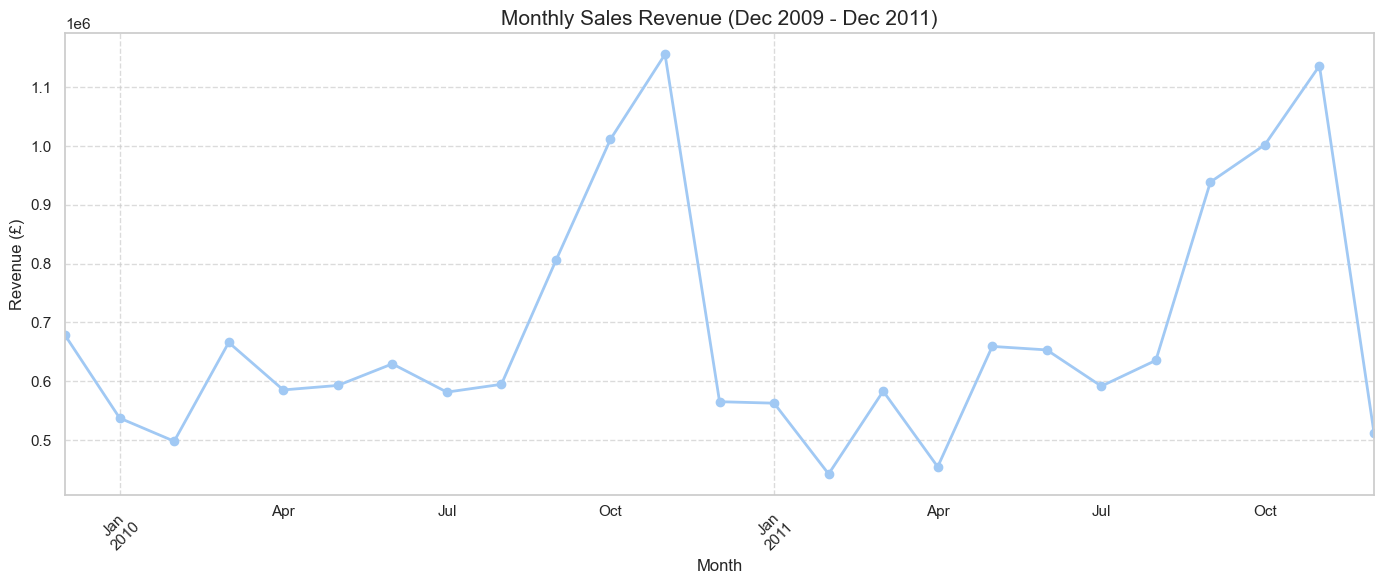

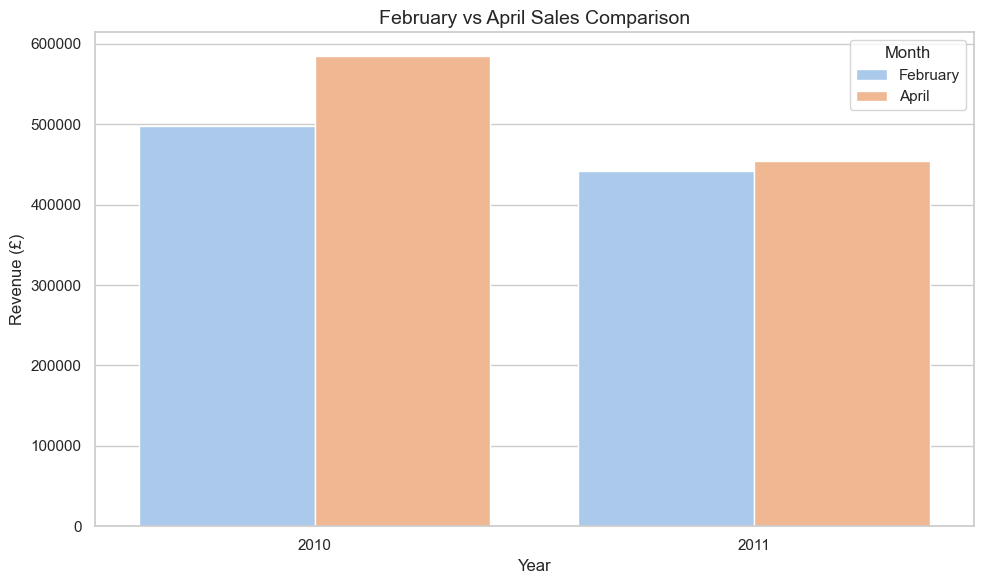

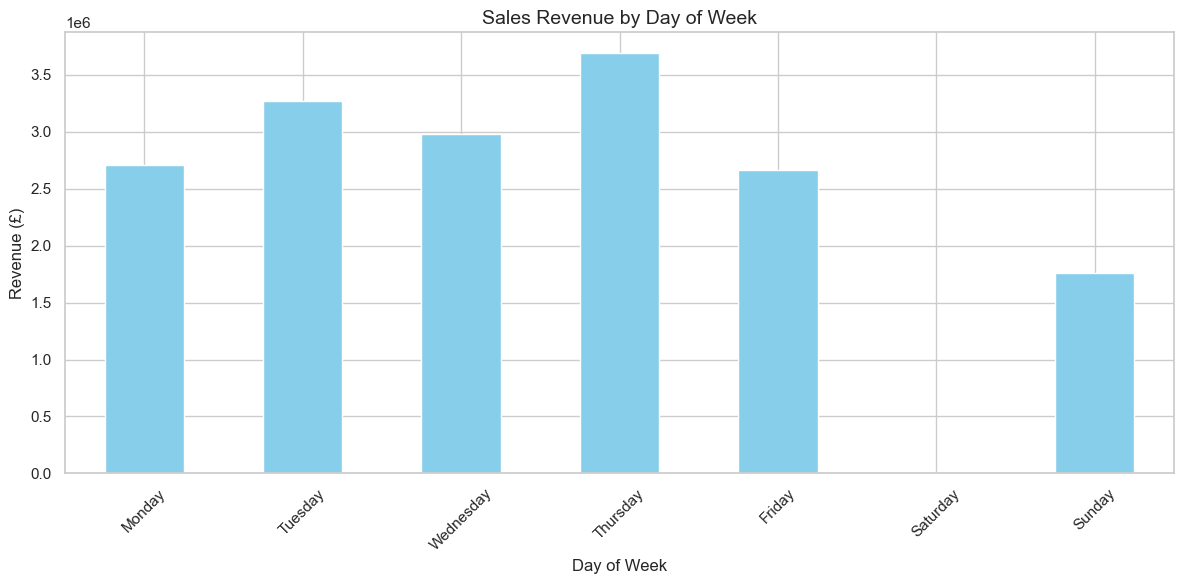

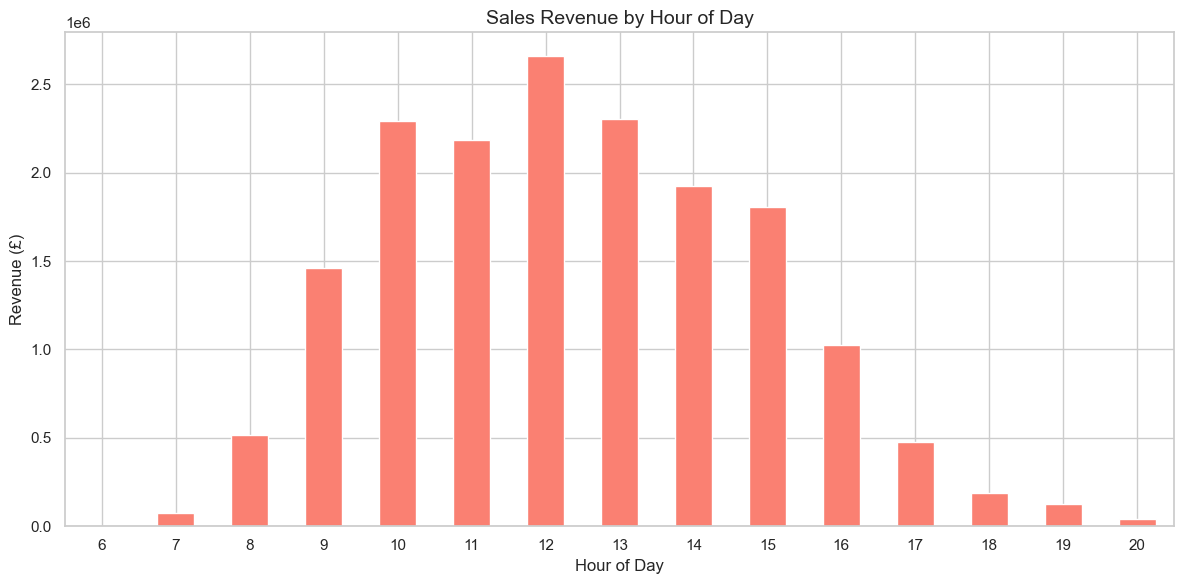

In [4]:
# Monthly Sales Revenue Analysis
monthly_sales = get_monthly_sales(df)

plt.figure(figsize=(14, 6))
monthly_sales.plot(kind='line', marker='o', linewidth=2)
plt.title('Monthly Sales Revenue (Dec 2009 - Dec 2011)', fontsize=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
save_plot(plt.gcf(), '../figures/temporal/monthly_sales.png')

# Investigate February and April dips
feb_apr_comparison = get_feb_apr_comparison(monthly_sales)

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='TotalPrice', hue='Month', data=feb_apr_comparison)
plt.title('February vs April Sales Comparison', fontsize=14)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xlabel('Year', fontsize=12)
save_plot(plt.gcf(), '../figures/temporal/feb_apr_comparison.png')

# Daily and Hourly Sales Patterns
daily_sales = get_daily_sales(df)

plt.figure(figsize=(12, 6))
daily_sales.plot(kind='bar', color='skyblue')
plt.title('Sales Revenue by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=45)
save_plot(plt.gcf(), '../figures/temporal/daily_sales.png')

# Hourly pattern
hourly_sales = get_hourly_sales(df)

plt.figure(figsize=(12, 6))
hourly_sales.plot(kind='bar', color='salmon')
plt.title('Sales Revenue by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=0)
save_plot(plt.gcf(), '../figures/temporal/hourly_sales.png')

This section addresses **Objective 1 (Temporal Analysis)** and **Objective 4 (Behavioral Patterns)**.
- **Monthly Trends:** Analyzing overall sales trends, seasonality, and investigating specific dips in February and April.
- **Behavioral Patterns:** Identifying the highest revenue-generating days of the week and hours of the day.

### 2.2 Geographic Revenue Analysis
---

UK Contribution: 83.71%
International Contribution: 16.29%


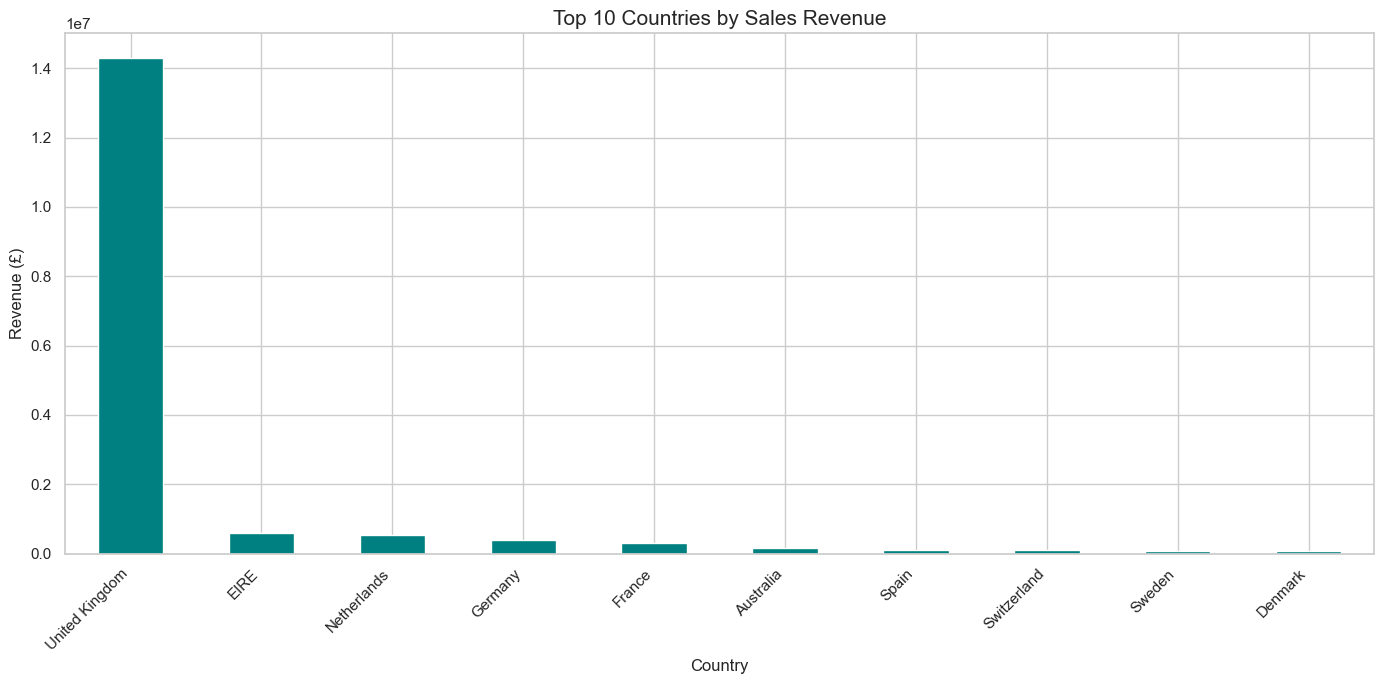

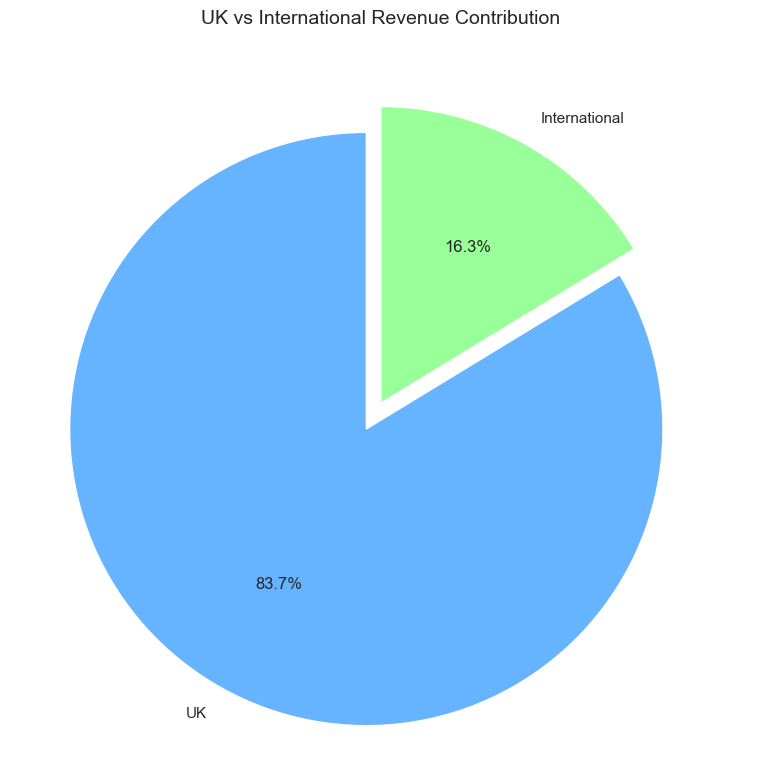

In [5]:
# Geographic Analysis
country_data = get_country_analysis(df)

# Display key metrics
print(f"UK Contribution: {country_data['uk_percentage']:.2f}%")
print(f"International Contribution: {100 - country_data['uk_percentage']:.2f}%")

# Visualization
plt.figure(figsize=(14, 7))
country_data['top_10_countries'].plot(kind='bar', color='teal')
plt.title('Top 10 Countries by Sales Revenue', fontsize=15)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.xticks(rotation=45, ha='right')
save_plot(plt.gcf(), '../figures/geographic/country_revenue.png')

# Pie chart for UK vs International
plt.figure(figsize=(8, 8))
plt.pie([country_data['uk_percentage'], 100 - country_data['uk_percentage']],
        labels=['UK', 'International'],
        autopct='%1.1f%%',
        colors=['#66b3ff','#99ff99'],
        startangle=90,
        explode=(0.1, 0))
plt.title('UK vs International Revenue Contribution', fontsize=14)
save_plot(plt.gcf(), '../figures/geographic/uk_vs_international.png')

This section addresses **Objective 2 (Geographic Analysis)**.
- **Market Distribution:** Identifying the top 10 countries by sales revenue and analyzing the contribution of the domestic UK market versus international sales.
- **Strategic Insight:** Understanding the geographic footprint of the business to prioritize market efforts.

### 2.3 Product Performance Analysis
---

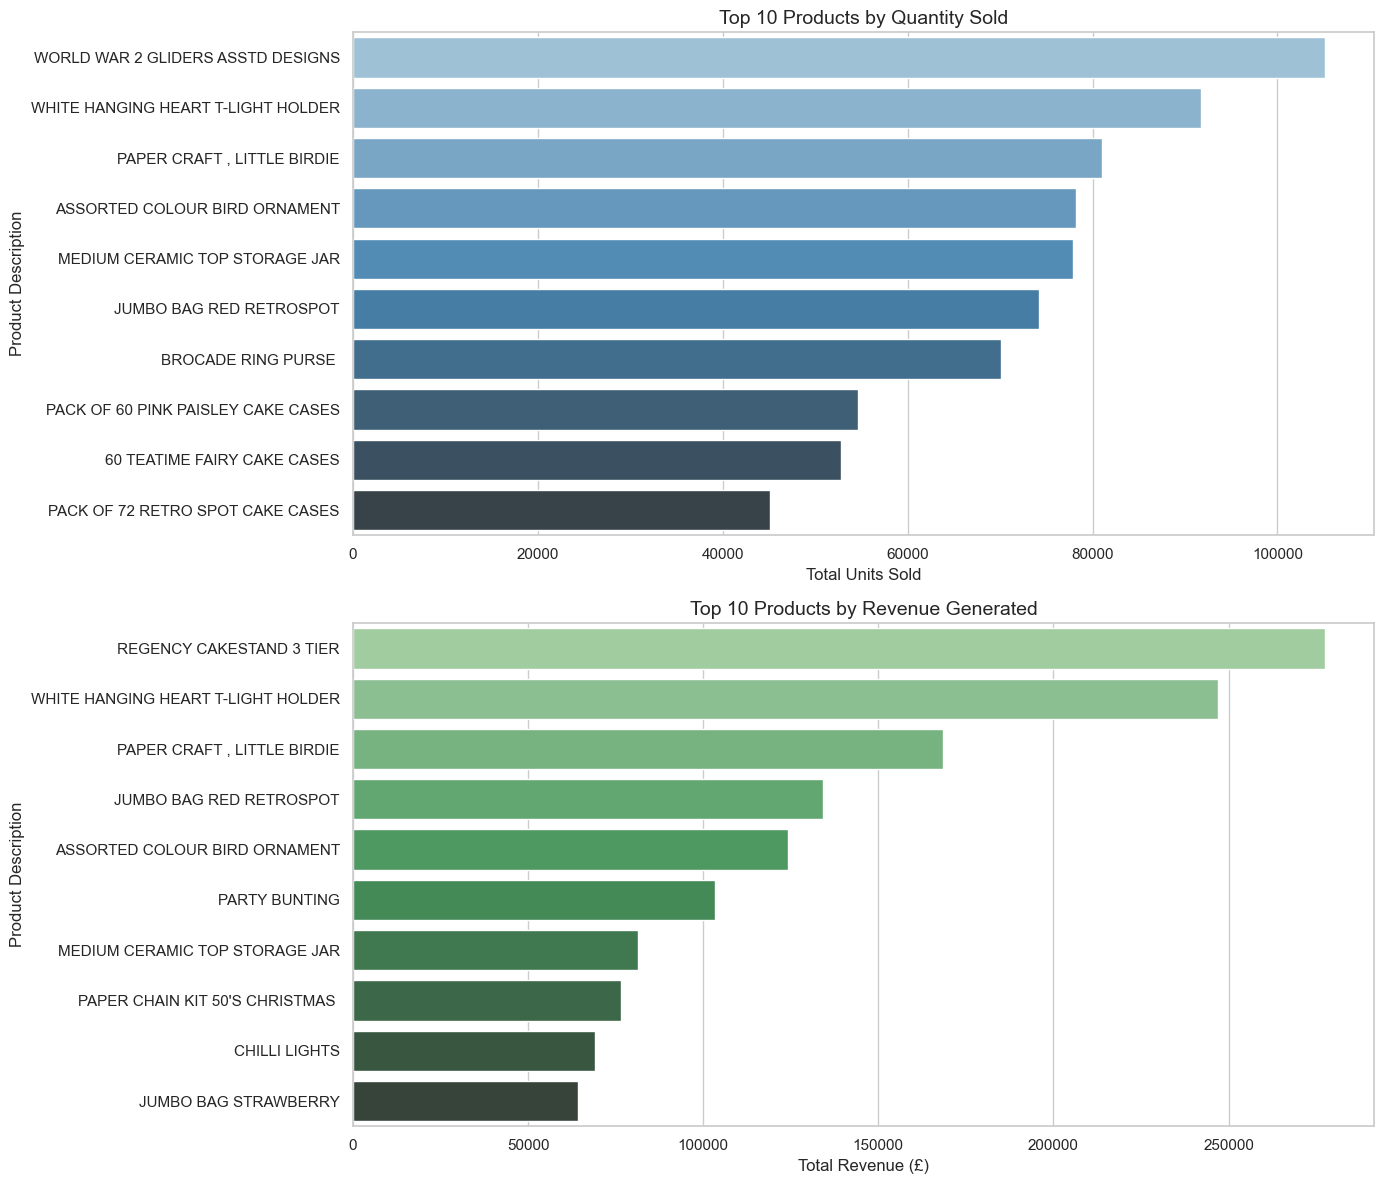


Product Portfolio Comparison:
Products appearing in both top lists: 5
Quantity-only products: 5
Revenue-only products: 5

Comparison Table:


,Description,TotalQuantity,TotalRevenue
0,60 TEATIME FAIRY CAKE CASES,52828.0,Not in Top 10
1,ASSORTED COLOUR BIRD ORNAMENT,78234.0,124351.86
2,BROCADE RING PURSE,70082.0,Not in Top 10
3,CHILLI LIGHTS,Not in Top 10,69084.3
4,JUMBO BAG RED RETROSPOT,74224.0,134307.44
5,JUMBO BAG STRAWBERRY,Not in Top 10,64127.77
6,MEDIUM CERAMIC TOP STORAGE JAR,77916.0,81416.73
7,PACK OF 60 PINK PAISLEY CAKE CASES,54592.0,Not in Top 10
8,PACK OF 72 RETRO SPOT CAKE CASES,45129.0,Not in Top 10
9,PAPER CHAIN KIT 50'S CHRISTMAS,Not in Top 10,76598.18


In [6]:
# Product Performance Analysis
product_data = get_product_analysis(df)

# Visualizations
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Quantity plot
sns.barplot(x='TotalQuantity', y='Description', data=product_data['top_quantity'],
            ax=ax[0], palette='Blues_d')
ax[0].set_title('Top 10 Products by Quantity Sold', fontsize=14)
ax[0].set_xlabel('Total Units Sold', fontsize=12)
ax[0].set_ylabel('Product Description', fontsize=12)

# Revenue plot
sns.barplot(x='TotalRevenue', y='Description', data=product_data['top_revenue'],
            ax=ax[1], palette='Greens_d')
ax[1].set_title('Top 10 Products by Revenue Generated', fontsize=14)
ax[1].set_xlabel('Total Revenue (£)', fontsize=12)
ax[1].set_ylabel('Product Description', fontsize=12)

save_plot(fig, '../figures/products/product_performance.png')

# Comparison analysis
comparison_df = product_data['comparison']

print("\nProduct Portfolio Comparison:")
print(f"Products appearing in both top lists: {comparison_df[comparison_df['_merge'] == 'both'].shape[0]}")
print(f"Quantity-only products: {comparison_df[comparison_df['_merge'] == 'left_only'].shape[0]}")
print(f"Revenue-only products: {comparison_df[comparison_df['_merge'] == 'right_only'].shape[0]}")

# Create a comparison table
comparison_table = pd.merge(
    product_data['top_quantity'][['Description', 'TotalQuantity']],
    product_data['top_revenue'][['Description', 'TotalRevenue']],
    on='Description',
    how='outer'
).fillna('Not in Top 10')

print("\nComparison Table:")
display(comparison_table)

This section addresses **Objective 3 (Product Performance)**.
- **Portfolio Analysis:** Identifying the top 10 products by both quantity sold and revenue generated.
- **Strategic Comparison:** Contrasting high-volume products with high-value products to inform inventory, marketing, and pricing strategies.

# Phase 3: Advanced Analytics - RFM Customer Segmentation
---

**Team:** Code Serpents

**Team Member:** G. A. Dilsara Thiranjaya

---

## Executive Summary

This notebook implements a comprehensive RFM (Recency, Frequency, Monetary) analysis to segment customers of "Unique Gifts Ltd." based on their purchasing behavior. The analysis will help identify high-value customers, at-risk segments, and opportunities for targeted marketing strategies.

## Objectives

1. **Calculate RFM Metrics**: Compute Recency, Frequency, and Monetary values for each customer
2. **Assign RFM Scores**: Use quintile-based scoring (1-5) for each RFM dimension
3. **Customer Segmentation**: Map RFM scores to descriptive business segments

---

### 3.1 Run Complete RFM Analysis
---

In [7]:
# Execute the complete RFM analysis workflow
results = run_complete_analysis(df)

# Extract results for easy access
rfm_data = results['rfm_data']
rfm_scored = results['rfm_scored']
rfm_final = results['rfm_final']
segment_summary = results['segment_summary']
summary_stats = results['summary_stats']

print("\nRFM Analysis completed successfully!")

Starting RFM Analysis...
Data validation passed. All required columns are present.
RFM Analysis Complete!

RFM Analysis completed successfully!


### 3.2 RFM Metrics Analysis
---
#### Basic RFM Statistics

In [8]:
# Display comprehensive summary statistics
print("RFM ANALYSIS SUMMARY STATISTICS")
print("=" * 50)

print(f"\nAnalysis Overview:")
print(f"Total Customers Analyzed: {summary_stats['total_customers']:,}")
print(f"Analysis Period: {summary_stats['data_period']['start_date'].strftime('%Y-%m-%d')} to {summary_stats['data_period']['end_date'].strftime('%Y-%m-%d')}")
print(f"Snapshot Date: {summary_stats['snapshot_date'].strftime('%Y-%m-%d')}")

print(f"\nRecency Statistics (Days since last purchase):")
print(summary_stats['recency_stats'])

print(f"\nFrequency Statistics (Number of transactions):")
print(summary_stats['frequency_stats'])

print(f"\nMonetary Statistics (Total spent in £):")
print(summary_stats['monetary_stats'])

# Display sample of RFM data
print("\nSample RFM Data:")
display(rfm_data.head(10))

RFM ANALYSIS SUMMARY STATISTICS

Analysis Overview:
Total Customers Analyzed: 5,861
Analysis Period: 2009-12-01 to 2011-12-09
Snapshot Date: 2011-12-10

Recency Statistics (Days since last purchase):
count    5861.000000
mean      200.937895
std       209.201911
min         1.000000
25%        26.000000
50%        96.000000
75%       379.000000
max       739.000000
Name: Recency, dtype: float64

Frequency Statistics (Number of transactions):
count    5861.000000
mean        6.252175
std        12.778230
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       376.000000
Name: Frequency, dtype: float64

Monetary Statistics (Total spent in £):
count      5861.000000
mean       2913.065381
std       14300.687269
min           2.950000
25%         338.130000
50%         854.990000
75%        2237.120000
max      580987.040000
Name: Monetary, dtype: float64

Sample RFM Data:


,Customer ID,Recency,Frequency,Monetary
0,12346,326,12,77556.46
1,12347,2,8,4921.53
2,12348,75,5,1658.40
3,12349,19,3,3678.69
4,12350,310,1,294.40
5,12351,375,1,300.93
6,12352,36,9,1729.54
7,12353,204,2,406.76
8,12354,232,1,1079.40
9,12355,214,2,947.61


#### RFM Scores and Segments

In [9]:
# Display RFM scores and segments
print("RFM SCORES AND CUSTOMER SEGMENTS")
print("=" * 50)

print("\nSample of RFM Scored Data:")
display(rfm_scored.head(10))

print("\nSample of Final Segmented Data:")
display(rfm_final.head(10))

print("\nRFM Score Distribution:")
score_dist = pd.DataFrame({
    'R_Score': rfm_scored['R_Score'].value_counts().sort_index(),
    'F_Score': rfm_scored['F_Score'].value_counts().sort_index(),
    'M_Score': rfm_scored['M_Score'].value_counts().sort_index()
})
display(score_dist)

RFM SCORES AND CUSTOMER SEGMENTS

Sample of RFM Scored Data:


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment
0,12346,326,12,77556.46,2,5,5,255
1,12347,2,8,4921.53,5,4,5,545
2,12348,75,5,1658.40,3,4,4,344
3,12349,19,3,3678.69,5,3,5,535
4,12350,310,1,294.40,2,1,2,212
5,12351,375,1,300.93,2,1,2,212
6,12352,36,9,1729.54,4,5,4,454
7,12353,204,2,406.76,2,2,2,222
8,12354,232,1,1079.40,2,1,3,213
9,12355,214,2,947.61,2,2,3,223



Sample of Final Segmented Data:


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,Segment
0,12346,326,12,77556.46,2,5,5,255,At-Risk Customers
1,12347,2,8,4921.53,5,4,5,545,Champions
2,12348,75,5,1658.40,3,4,4,344,Loyal Customers
3,12349,19,3,3678.69,5,3,5,535,NaN
4,12350,310,1,294.40,2,1,2,212,Hibernating
5,12351,375,1,300.93,2,1,2,212,Hibernating
6,12352,36,9,1729.54,4,5,4,454,Champions
7,12353,204,2,406.76,2,2,2,222,Hibernating
8,12354,232,1,1079.40,2,1,3,213,Hibernating
9,12355,214,2,947.61,2,2,3,223,Hibernating



RFM Score Distribution:


,R_Score,F_Score,M_Score
1,1172,1173,1173
2,1169,1172,1172
3,1159,1172,1172
4,1174,1172,1172
5,1187,1172,1172


### 3.3 Customer Segment Analysis
---
#### Segment Summary Statistics

In [10]:
# Display comprehensive segment analysis
print("CUSTOMER SEGMENT ANALYSIS")
print("=" * 50)

print("\nSegment Summary (Sorted by Customer Count):")
display(segment_summary)

print("\nKey Segment Insights:")
print(f"• Largest Segment: {segment_summary.index[0]} ({segment_summary.iloc[0]['Customer_Count']:,} customers, {segment_summary.iloc[0]['Customer_Percentage']:.1f}%)")
print(f"• Highest Revenue Segment: {segment_summary.sort_values('Total_Revenue', ascending=False).index[0]}")
print(f"• Highest Average Spend: {segment_summary.sort_values('Avg_Monetary', ascending=False).index[0]} (£{segment_summary.sort_values('Avg_Monetary', ascending=False).iloc[0]['Avg_Monetary']:,.2f})")

# Segment distribution
print(f"\nCustomer Distribution Across Segments:")
segment_counts = rfm_final['Segment'].value_counts()
for segment, count in segment_counts.items():
    percentage = (count / len(rfm_final)) * 100
    print(f"• {segment}: {count:,} customers ({percentage:.1f}%)")

CUSTOMER SEGMENT ANALYSIS

Segment Summary (Sorted by Customer Count):


,Customer_Count,Avg_Recency,Median_Recency,Avg_Frequency,Median_Frequency,Avg_Monetary,Median_Monetary,Total_Revenue,Customer_Percentage,Revenue_Percentage
Segment,,,,,,,,,,
Hibernating,1514,458.27,433.0,1.25,1.0,408.70,273.28,618775.42,31.67,3.85
Champions,1292,19.98,16.0,17.00,11.0,9024.47,3900.97,11659619.10,27.02,72.49
At-Risk Customers,827,369.20,374.0,4.97,4.0,1921.52,1015.24,1589096.32,17.30,9.88
Loyal Customers,697,84.13,78.0,7.63,6.0,2582.84,1608.93,1800237.63,14.58,11.19
Potential Loyalists,451,28.13,26.0,1.46,1.0,923.31,365.45,416414.78,9.43,2.59



Key Segment Insights:
• Largest Segment: Hibernating (1,514.0 customers, 31.7%)
• Highest Revenue Segment: Champions
• Highest Average Spend: Champions (£9,024.47)

Customer Distribution Across Segments:
• Hibernating: 1,514 customers (25.8%)
• Champions: 1,292 customers (22.0%)
• At-Risk Customers: 827 customers (14.1%)
• Loyal Customers: 697 customers (11.9%)
• Potential Loyalists: 451 customers (7.7%)


#### Detailed Segment Characteristics

In [11]:

# Analyze segment characteristics in detail
print("DETAILED SEGMENT CHARACTERISTICS")
print("=" * 50)

for segment in segment_summary.index:
    segment_data = segment_summary.loc[segment]
    
    print(f"\n{segment.upper()}:")
    print(f"   Customers: {segment_data['Customer_Count']:,} ({segment_data['Customer_Percentage']:.1f}% of total)")
    print(f"   Revenue: £{segment_data['Total_Revenue']:,.2f} ({segment_data['Revenue_Percentage']:.1f}% of total)")
    print(f"   Avg Recency: {segment_data['Avg_Recency']:.0f} days")
    print(f"   Avg Frequency: {segment_data['Avg_Frequency']:.1f} transactions")
    print(f"   Avg Monetary: £{segment_data['Avg_Monetary']:,.2f}")
    
    # Add business interpretation
    if 'Champions' in segment:
        print(f"   Interpretation: These are your best customers - recent, frequent, high-value purchases")
    elif 'Loyal' in segment:
        print(f"   Interpretation: Regular customers who respond well to promotions")
    elif 'At-Risk' in segment:
        print(f"   Interpretation: Previously valuable customers who may be churning - need retention efforts")
    elif 'New' in segment:
        print(f"   Interpretation: Recent customers with growth potential - focus on onboarding")
    elif 'Hibernating' in segment:
        print(f"   Interpretation: Inactive customers - evaluate cost-effectiveness of win-back campaigns")
    elif 'Cannot Lose' in segment:
        print(f"   Interpretation: High-value customers at risk - prioritize immediate retention efforts")
    else:
        print(f"   Interpretation: Unique segment requiring tailored marketing approach")

DETAILED SEGMENT CHARACTERISTICS

HIBERNATING:
   Customers: 1,514.0 (31.7% of total)
   Revenue: £618,775.42 (3.9% of total)
   Avg Recency: 458 days
   Avg Frequency: 1.2 transactions
   Avg Monetary: £408.70
   Interpretation: Inactive customers - evaluate cost-effectiveness of win-back campaigns

CHAMPIONS:
   Customers: 1,292.0 (27.0% of total)
   Revenue: £11,659,619.10 (72.5% of total)
   Avg Recency: 20 days
   Avg Frequency: 17.0 transactions
   Avg Monetary: £9,024.47
   Interpretation: These are your best customers - recent, frequent, high-value purchases

AT-RISK CUSTOMERS:
   Customers: 827.0 (17.3% of total)
   Revenue: £1,589,096.32 (9.9% of total)
   Avg Recency: 369 days
   Avg Frequency: 5.0 transactions
   Avg Monetary: £1,921.52
   Interpretation: Previously valuable customers who may be churning - need retention efforts

LOYAL CUSTOMERS:
   Customers: 697.0 (14.6% of total)
   Revenue: £1,800,237.63 (11.2% of total)
   Avg Recency: 84 days
   Avg Frequency: 7.6 tra

### 3.4 Data Visualizations
---
#### Generate All Visualizations

Creating RFM distribution plots...
Creating segment analysis plots...
All visualizations generated successfully!
Generated 2 visualization sets:
• Distributions Analysis
• Segments Analysis


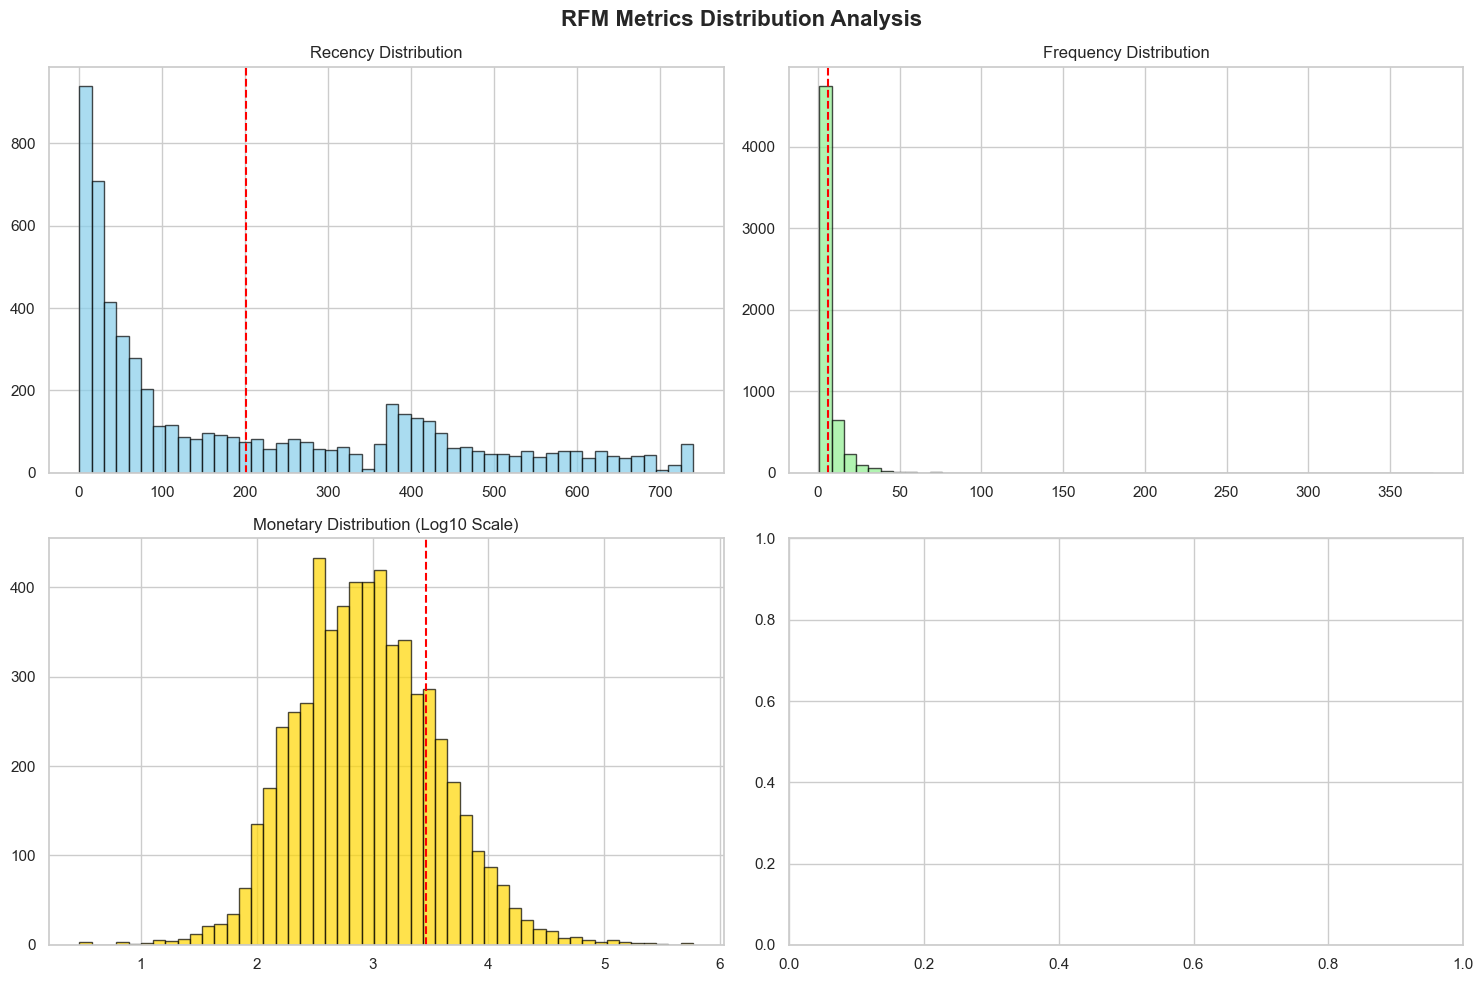

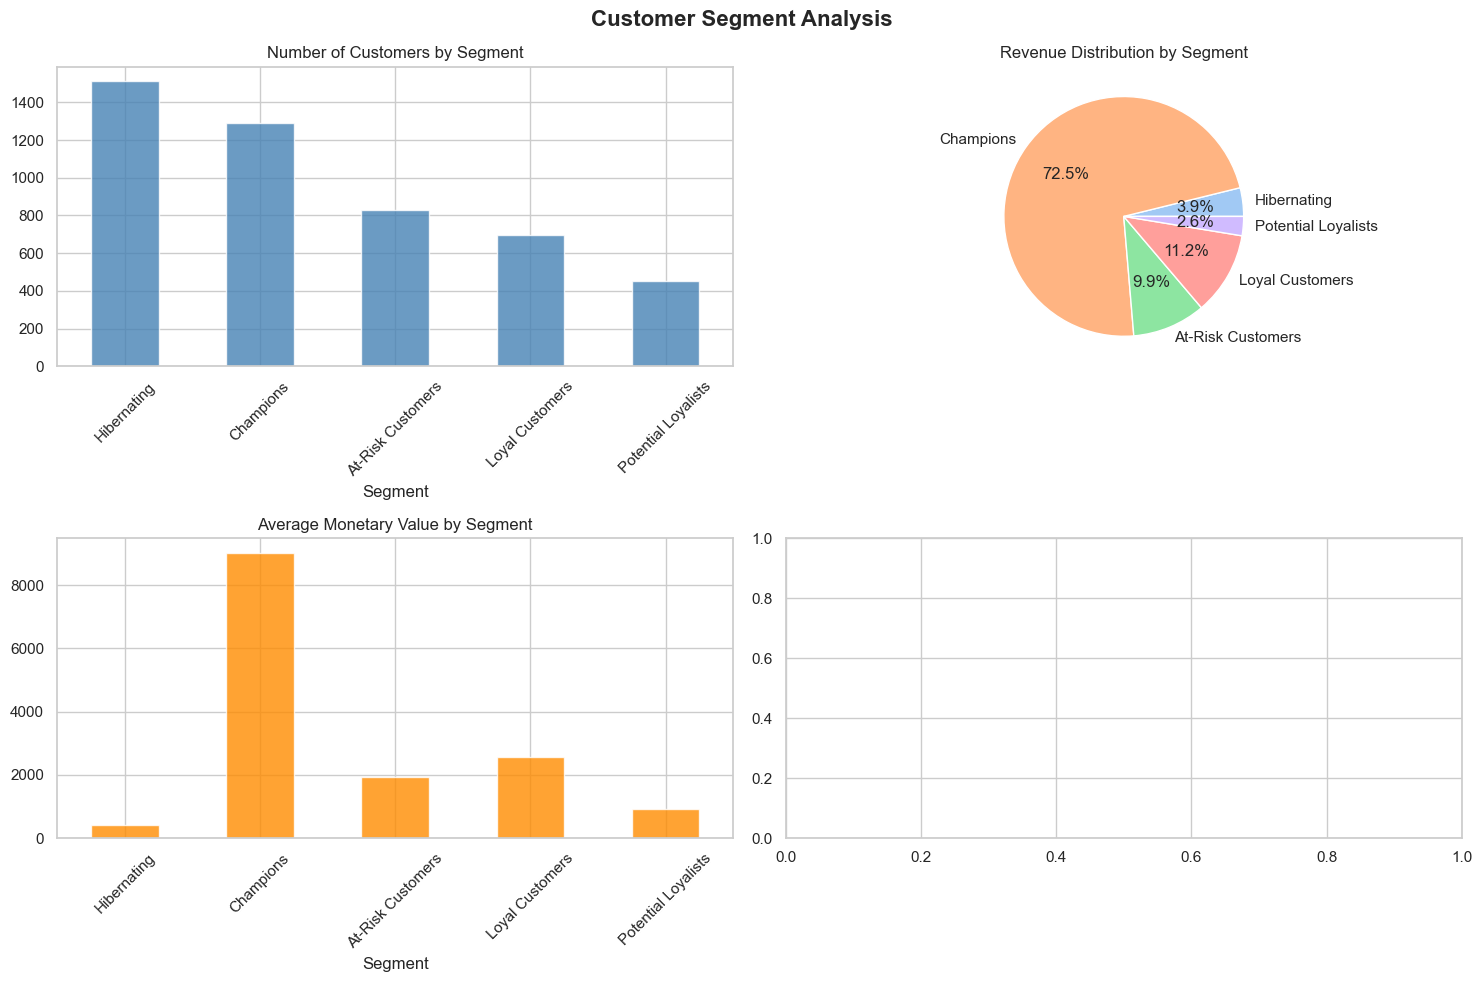

In [12]:
# Generate comprehensive visualizations
figures = generate_visualizations(rfm_final, segment_summary)

print("All visualizations generated successfully!")
print(f"Generated {len(figures)} visualization sets:")
for fig_name in figures.keys():
    print(f"• {fig_name.title()} Analysis")

**Analysis of RFM Distributions:**

- **Recency Distribution**: Shows the distribution of days since last purchase. A right-skewed distribution indicates most customers purchased recently, with a tail of customers who haven't purchased in a long time.

- **Frequency Distribution**: Displays the number of transactions per customer. Typically right-skewed, showing most customers make few purchases, while a small group makes many purchases.

- **Monetary Distribution (Log Scale)**: Shows customer spending patterns. The log scale helps visualize the wide range of spending behaviors and potential bimodal distribution suggesting retail vs. wholesale customers.

**Segment Analysis Insights:**

- **Customer Count by Segment**: Shows the relative size of each customer segment
- **Revenue Distribution**: Reveals which segments contribute most to total revenue
- **Average Monetary Value**: Identifies the highest-spending segments

### 3.5 Export Results
---
#### Export to Excel and Save charts

In [13]:
# Export comprehensive results to Excel and 
export_results_phase_3(rfm_final, segment_summary)

Creating RFM distribution plots...
Creating segment analysis plots...
Chart saved: ../figures/rfm_charts/distributions.png
Chart saved: ../figures/rfm_charts/segments.png
Results exported to ../results/phase_3/rfm_analysis_results.xlsx


#### Export Key DataFrames for Integration

In [14]:
# Save key results for integration with other phases
output_dir = "../results/phase_3/"
os.makedirs(output_dir, exist_ok=True)

# Save individual CSV files
rfm_final.to_csv(f"{output_dir}rfm_customer_segments.csv", index=False)
segment_summary.to_csv(f"{output_dir}segment_summary_statistics.csv")

print(f"Results saved to {output_dir}")
print("Files created:")
print("• rfm_customer_segments.csv")
print("• segment_summary_statistics.csv")

Results saved to ../results/phase_3/
Files created:
• rfm_customer_segments.csv
• segment_summary_statistics.csv


# Phase 4: Strategic Recommendations
---

**Team:** Code Serpents

**Team Member:** K. D. Vihanga Heshan Bandara

---

## Executive Summary

This notebook translates analytical findings into actionable business strategies. It investigates the wholesaler hypothesis and provides data-driven recommendations for customer segmentation, marketing strategies, and business growth opportunities.

## Objectives

1. **Wholesaler Analysis**: Investigate purchasing behavior differences between wholesalers and retail customers
2. **Segment Strategy**: Develop targeted strategies for each RFM customer segment
3. **Strategic Recommendations**: Provide actionable insights for marketing, inventory, and customer relationship management

---

# Phase 5: Data Enrichment via API Integration
---

**Team:** Code Serpents

**Team Member:** K. Lahiru Chanaka

---

## Executive Summary

This notebook demonstrates advanced data acquisition skills by integrating external currency exchange data through API calls. The enrichment enhances the dataset for international financial reporting and regional pricing strategies.

## Objectives

1. **API Integration**: Connect to a free currency conversion API using requests library
2. **Data Enrichment**: Convert transaction values to USD and EUR for top transactions
3. **Business Value**: Demonstrate the practical application of external data integration for international business operations

---

### 5.1 Identify the Top 100 Transactions
---

We'll identify the top 100 transactions by TotalPrice value, as specified in the project requirements. These high-value transactions are most important for currency conversion analysis.

In [15]:
top_100_transactions = df.nlargest(100, 'TotalPrice').copy()

print("Top 100 Transactions Analysis:")
print(f"   - Highest transaction value: £{top_100_transactions['TotalPrice'].max():.2f}")
print(f"   - Lowest transaction value in top 100: £{top_100_transactions['TotalPrice'].min():.2f}")
print(f"   - Average transaction value: £{top_100_transactions['TotalPrice'].mean():.2f}")
print(f"   - Total value of top 100: £{top_100_transactions['TotalPrice'].sum():.2f}")

Top 100 Transactions Analysis:
   - Highest transaction value: £168469.60
   - Lowest transaction value in top 100: £2328.48
   - Average transaction value: £6209.15
   - Total value of top 100: £620914.70


### 5.2 Currency Conversion API Integration
---

We'll use 'ExchangeRate-API', a free currency conversion service. This section includes:

#### Fetch Current Exchange Rates

Let's fetch the current exchange rates from the API. We'll implement proper error handling to ensure our analysis can continue even if the API is temporarily unavailable.

In [16]:
exchange_data = fetch_exchange_rates(BASE_CURRENCY)

if exchange_data:
    rates = exchange_data['rates']
    rate_date = exchange_data['date']

    print(f"Exchange rates fetched on {rate_date}.")
    print(f"Base currency: {BASE_CURRENCY}")

    for currency in TARGET_CURRENCIES:
        if currency in rates:
            print(f"Exchange rate for {currency}: {rates[currency]}")
        else:
            print(f"Exchange rate for {currency} not found in the API response.")

else:
    print("Failed to fetch exchange rates. Please check your API configuration or network connection.")

    # Fallback rates (approximate values)
    exchange_data = {
        'date': datetime.now().strftime('%Y-%m-%d'),
        'base': BASE_CURRENCY,
        'rates': {
            'USD': 1.25,
            'EUR': 1.15
        }
    }

    rates = exchange_data['rates']
    rate_date = exchange_data['date']

    print(f"Using fallback exchange rates for {rate_date}.")

    for currency in TARGET_CURRENCIES:
        print(f"Fallback exchange rate for {currency}: {rates[currency]}")

Fetching exchange rates (attempt 1/3)...
Unexpected API response format.
Failed to fetch exchange rates. Please check your API configuration or network connection.
Using fallback exchange rates for 2025-08-26.
Fallback exchange rate for USD: 1.25
Fallback exchange rate for EUR: 1.15


### 5.3 Apply Currency Conversion to Top 100 Transactions
---

Now we'll apply the currency conversion to our top 100 transactions, creating new columns for USD and EUR values.

In [17]:
# Create a copy of the top 100 transactions for currency conversion
top_100_with_currency = top_100_transactions.copy()

# Add exchange rate information
top_100_with_currency['ExchangeRateDate'] = rate_date
top_100_with_currency['GBP_to_USD_Rate'] = rates.get('USD', None)
top_100_with_currency['GBP_to_EUR_Rate'] = rates.get('EUR', None)

# Convert TotalPrice to USD and EUR
print(f"Converting transaction values to multiple currencies...")

# USD Conversion
if 'USD' in rates:
    top_100_with_currency['TotalPrice_USD'] = top_100_with_currency['TotalPrice'].apply(
        lambda x: convert_currency(x, 'GBP', 'USD', exchange_data)
    )
    print(f"Successfully converted TotalPrice to USD.")

else:
    top_100_with_currency['TotalPrice_USD'] = None
    print("Exchange rate for USD not found in the API response.")

# EUR Conversion
if 'EUR' in rates:
    top_100_with_currency['TotalPrice_EUR'] = top_100_with_currency['TotalPrice'].apply(
        lambda x: convert_currency(x, 'GBP', 'EUR', exchange_data)
    )
    print(f"Successfully converted TotalPrice to EUR.")

else:
    top_100_with_currency['TotalPrice_EUR'] = None
    print("Exchange rate for EUR not found in the API response.")

# Display conversion summary
print(f"Currency Conversion Summary:")
print(f"    - Original GBP total: £{top_100_with_currency['TotalPrice'].sum():.2f}")

if top_100_with_currency['TotalPrice_USD'].notna().any():
    usd_total = top_100_with_currency['TotalPrice_USD'].sum()
    print(f"    - Converted USD total: ${usd_total:.2f}")

if top_100_with_currency['TotalPrice_EUR'].notna().any():
    eur_total = top_100_with_currency['TotalPrice_EUR'].sum()
    print(f"    - Converted EUR total: €{eur_total:.2f}")
     

Converting transaction values to multiple currencies...
Successfully converted TotalPrice to USD.
Successfully converted TotalPrice to EUR.
Currency Conversion Summary:
    - Original GBP total: £620914.70
    - Converted USD total: $776143.38
    - Converted EUR total: €714051.91


### 5.4 Data Validation and Quality Checks
---

It's important to validate our currency conversion results to ensure accuracy and identify any potential issues.

In [18]:
# Check for any conversion failures
usd_failures = top_100_with_currency['TotalPrice_USD'].isna().sum()
eur_failures = top_100_with_currency['TotalPrice_EUR'].isna().sum()
total_transactions = len(top_100_with_currency)

print(f"Convertion Quality Report:")
print(f"    - Total transactional processed: {total_transactions}")
print(f"    - USD conversion failures: {usd_failures}")
print(f"    - EUR conversion failures: {eur_failures}")
print(f"    - Success rate: {(total_transactions - usd_failures - eur_failures) / total_transactions * 100:.2f}%")

# Check if any values that might indicate errors
if top_100_with_currency['TotalPrice_USD'].notna().any():
    usd_values = top_100_with_currency['TotalPrice_USD'].dropna()
    usd_mean = usd_values.mean()
    usd_std = usd_values.std()
    outliers_usd = usd_values[(usd_values > usd_mean + 3 * usd_std) | (usd_values < usd_mean - 3 * usd_std)]
    print(f"    - USD outliers found: {len(outliers_usd)}")

if top_100_with_currency['TotalPrice_EUR'].notna().any():
    eur_values = top_100_with_currency['TotalPrice_EUR'].dropna()
    eur_mean = eur_values.mean()
    eur_std = eur_values.std()
    outliers_eur = eur_values[(eur_values > eur_mean + 3 * eur_std) | (eur_values < eur_mean - 3 * eur_std)]
    print(f"    - EUR outliers found: {len(outliers_eur)}")

print()
print("Data validation completed")

Convertion Quality Report:
    - Total transactional processed: 100
    - USD conversion failures: 0
    - EUR conversion failures: 0
    - Success rate: 100.00%
    - USD outliers found: 2
    - EUR outliers found: 2

Data validation completed


### 5.5 Display Results and Analysis
---

Let's examine our currency-converted data and display the results in a meaningful way.

In [19]:
# Display the top 10 transactions for demonstration purposes
print("Top 10 Transactions with Currency Conversion:")
print("=" * 50)

display_columns = ['Invoice', 'TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']

if 'Country' in top_100_with_currency.columns:
    display_columns.insert(1, 'Country')

if 'InvoiceDate' in top_100_with_currency.columns:
    display_columns.insert(1, 'InvoiceDate')

# Select the top 10 transactions
top_10_display = top_100_with_currency[display_columns].head(10).copy()

# Format the currency columns for better readability
if 'TotalPrice' in top_10_display.columns:
    top_10_display['TotalPrice_GBP'] = top_10_display['TotalPrice'].apply(lambda x: f"£{x:.2f}")

if 'TotalPrice_USD' in top_10_display.columns:
    top_10_display['TotalPrice_USD_formatted'] = top_10_display['TotalPrice_USD'].apply(lambda x: f"${x:.2f}" if pd.notna(x) else "N/A")

if 'TotalPrice_EUR' in top_10_display.columns:
    top_10_display['TotalPrice_EUR_formatted'] = top_10_display['TotalPrice_EUR'].apply(lambda x: f"€{x:.2f}" if pd.notna(x) else "N/A")

# Display formatted results
print(top_10_display[['Invoice', 'TotalPrice_GBP', 'TotalPrice_USD_formatted', 'TotalPrice_EUR_formatted']].to_string(index=False))

Top 10 Transactions with Currency Conversion:
 Invoice TotalPrice_GBP TotalPrice_USD_formatted TotalPrice_EUR_formatted
  581483     £168469.60               $210587.00               €193740.04
  541431      £77183.60                $96479.50                €88761.14
  556444      £38970.00                $48712.50                €44815.50
  530715      £15818.40                $19773.00                €18191.16
  511465       £8925.00                $11156.25                €10263.75
  567423       £7144.72                 $8930.90                 €8216.43
  540815       £6539.40                 $8174.25                 €7520.31
  550461       £6539.40                 $8174.25                 €7520.31
  525968       £5179.20                 $6474.00                 €5956.08
  573003       £4992.00                 $6240.00                 €5740.80


### 5.6 Statistical Summary and Comparison
---

Let's generate comprehensive statistics comparing the values across different currencies.

In [20]:
# Generate summary statistics
print("Statistical Summary Across Currencies:")
print("=" * 50)

# Calculate statistics for each currency
currencies = ['GBP', 'USD', 'EUR']
currency_columns = ['TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']
currency_symbols = ['£', '$', '€']

stats_summary = {}

for currency, column, symbol in zip(currencies, currency_columns, currency_symbols):
    if column in top_100_with_currency.columns:
        values = top_100_with_currency[column].dropna()

        if not values.empty:
            stats_summary[currency] = {
                'count': len(values),
                'mean': values.mean(),
                'median': values.median(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max(),
                'total': values.sum(),
                'symbol': symbol
            }

# Display formatted table
if stats_summary:
    print(f"{'Metric':<10} {'GBP':<15} {'USD':<15} {'EUR':<15}")
    print("-" * 55)

    metrics = ['count', 'mean', 'median', 'std', 'min', 'max', 'total']
    metric_names = ['Count', 'Mean', 'Median', 'Std Dev', 'Minimum', 'Maximum', 'Total']

    for metric, name in zip(metrics, metric_names):
        row = f"{name:<10}"

        for currency in currencies:
            if currency in stats_summary:
                if metric == 'count':
                    value = f"{stats_summary[currency][metric]}"
                else:
                    symbol = stats_summary[currency]['symbol']
                    value = f"{symbol}{stats_summary[currency][metric]:,.2f}"

                row += f" {value:<15}"

            else:
                row += f" {'N/A':<15}"

        print(row)

Statistical Summary Across Currencies:
Metric     GBP             USD             EUR            
-------------------------------------------------------
Count      100             100             100            
Mean       £6,209.15       $7,761.43       €7,140.52      
Median     £3,172.28       $3,965.35       €3,648.12      
Std Dev    £18,376.99      $22,971.24      €21,133.54     
Minimum    £2,328.48       $2,910.60       €2,677.75      
Maximum    £168,469.60     $210,587.00     €193,740.04    
Total      £620,914.70     $776,143.38     €714,051.91    


### 5.7 Visualization of Currency Conversions
---

Create visualizations to better understand the currency conversion results.

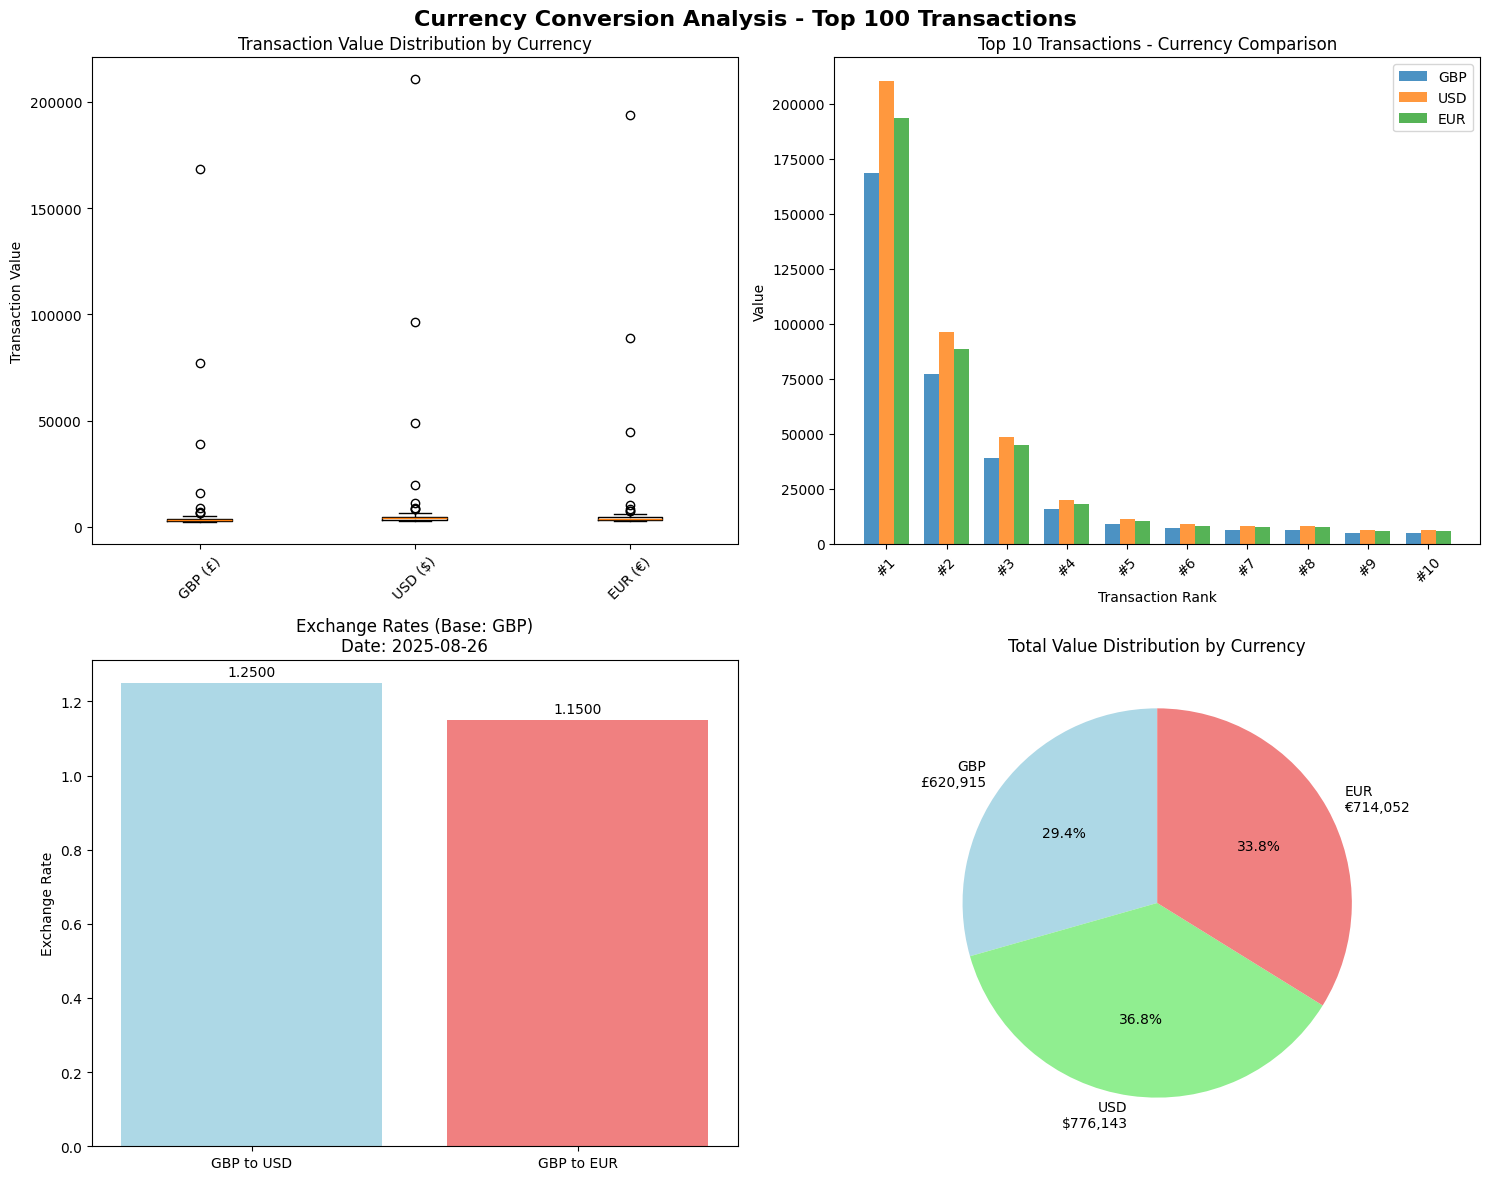

All charts have been exported to the 'currency_conversions' folder


In [21]:
# Create visualizations for currency comparison
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Currency Conversion Analysis - Top 100 Transactions', fontsize=16, fontweight='bold')

# 1. Compare of transaction values across currencies
ax1 = axes[0, 0]
currency_data = []
currency_labels = []

if 'TotalPrice' in top_100_with_currency.columns:
    currency_data.append(top_100_with_currency['TotalPrice'].dropna())
    currency_labels.append('GBP (£)')

if 'TotalPrice_USD' in top_100_with_currency.columns:
    usd_data = top_100_with_currency['TotalPrice_USD'].dropna()

    if not usd_data.empty:
        currency_data.append(usd_data)
        currency_labels.append('USD ($)')

if 'TotalPrice_EUR' in top_100_with_currency.columns:
    eur_data = top_100_with_currency['TotalPrice_EUR'].dropna()

    if not eur_data.empty:
        currency_data.append(eur_data)
        currency_labels.append('EUR (€)')

if currency_data:
    ax1.boxplot(currency_data, labels=currency_labels)
    ax1.set_title('Transaction Value Distribution by Currency')
    ax1.set_ylabel('Transaction Value')
    ax1.tick_params(axis='x', rotation=45)
else:
    ax1.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Transaction Value Distribution - No Data')

# 2. Top 10 transactions comparison
ax2 = axes[0, 1]
top_10 = top_100_with_currency.head(10)
x_pos = np.arange(len(top_10))

if not top_10.empty:
    width = 0.25

    if 'TotalPrice' in top_10.columns:
        ax2.bar(x_pos - width, top_10['TotalPrice'], width, label='GBP', alpha=0.8)

    if 'TotalPrice_USD' in top_10.columns and top_10['TotalPrice_USD'].notna().any():
        ax2.bar(x_pos, top_10['TotalPrice_USD'], width, label='USD', alpha=0.8)

    if 'TotalPrice_EUR' in top_10.columns and top_10['TotalPrice_EUR'].notna().any():
        ax2.bar(x_pos + width, top_10['TotalPrice_EUR'], width, label='EUR', alpha=0.8)

    ax2.set_title('Top 10 Transactions - Currency Comparison')
    ax2.set_xlabel('Transaction Rank')
    ax2.set_ylabel('Value')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'#{i+1}' for i in range(len(top_10))])
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

else:
    ax2.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Top 10 Transactions - No Data')

# 3. Exchange rate visualization
ax3 = axes[1, 0]

if rates:
    rate_currencies = []
    rate_values = []

    for currency in TARGET_CURRENCIES:
        if currency in rates:
            rate_currencies.append(f'GBP to {currency}')
            rate_values.append(rates[currency])

    if rate_currencies:
        bars = ax3.bar(rate_currencies, rate_values, color=['lightblue', 'lightcoral'])
        ax3.set_title(f'Exchange Rates (Base: GBP)\nDate: {rate_date}')
        ax3.set_ylabel('Exchange Rate')

        # Add value labels to bars
        for bar, value in zip(bars, rate_values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.4f}', ha='center', va='bottom')

    else:
        ax3.text(0.5, 0.5, 'No exchange rates available', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Exchange Rates - No Data')

else:
    ax3.text(0.5, 0.5, 'No exchange rates available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Exchange Rates - No Data')

# 4. Currency conversion summary pie chart
ax4 = axes[1, 1]

if stats_summary:
    total_values = [stats_summary[currency]['total'] for currency in currencies if currency in stats_summary]
    total_labels = [f"{currency}\n{stats_summary[currency]['symbol']}{stats_summary[currency]['total']:,.0f}"
                   for currency in currencies if currency in stats_summary]

    if total_values:
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        ax4.pie(total_values, labels=total_labels, autopct='%1.1f%%',
               colors=colors[:len(total_values)], startangle=90)
        ax4.set_title('Total Value Distribution by Currency')

    else:
        ax4.text(0.5, 0.5, 'No data for pie chart', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Total Value Distribution - No Data')

else:
    ax4.text(0.5, 0.5, 'No data for pie chart', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Total Value Distribution - No Data')

plt.tight_layout()

# Save the figure to the currency_conversions folder
plt.savefig('../figures/currency_conversions/currency_conversion_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Also save individual charts if needed
# 1. Save boxplot
fig1, ax1 = plt.subplots(figsize=(8, 6))
if currency_data:
    ax1.boxplot(currency_data, labels=currency_labels)
    ax1.set_title('Transaction Value Distribution by Currency')
    ax1.set_ylabel('Transaction Value')
    ax1.tick_params(axis='x', rotation=45)
    plt.savefig('../figures/currency_conversions/currency_distribution_boxplot.png', dpi=300, bbox_inches='tight')
plt.close(fig1)

# 2. Save top 10 transactions chart
fig2, ax2 = plt.subplots(figsize=(10, 6))
if not top_10.empty:
    width = 0.25
    if 'TotalPrice' in top_10.columns:
        ax2.bar(x_pos - width, top_10['TotalPrice'], width, label='GBP', alpha=0.8)
    if 'TotalPrice_USD' in top_10.columns and top_10['TotalPrice_USD'].notna().any():
        ax2.bar(x_pos, top_10['TotalPrice_USD'], width, label='USD', alpha=0.8)
    if 'TotalPrice_EUR' in top_10.columns and top_10['TotalPrice_EUR'].notna().any():
        ax2.bar(x_pos + width, top_10['TotalPrice_EUR'], width, label='EUR', alpha=0.8)
    
    ax2.set_title('Top 10 Transactions - Currency Comparison')
    ax2.set_xlabel('Transaction Rank')
    ax2.set_ylabel('Value')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f'#{i+1}' for i in range(len(top_10))])
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    plt.savefig('../figures/currency_conversions/top10_currency_comparison.png', dpi=300, bbox_inches='tight')
plt.close(fig2)

# 3. Save exchange rates chart
fig3, ax3 = plt.subplots(figsize=(8, 6))
if rates:
    rate_currencies = []
    rate_values = []
    for currency in TARGET_CURRENCIES:
        if currency in rates:
            rate_currencies.append(f'GBP to {currency}')
            rate_values.append(rates[currency])
    
    if rate_currencies:
        bars = ax3.bar(rate_currencies, rate_values, color=['lightblue', 'lightcoral'])
        ax3.set_title(f'Exchange Rates (Base: GBP)\nDate: {rate_date}')
        ax3.set_ylabel('Exchange Rate')
        for bar, value in zip(bars, rate_values):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{value:.4f}', ha='center', va='bottom')
        plt.savefig('../figures/currency_conversions/exchange_rates.png', dpi=300, bbox_inches='tight')
plt.close(fig3)

# 4. Save pie chart
fig4, ax4 = plt.subplots(figsize=(8, 6))
if stats_summary:
    total_values = [stats_summary[currency]['total'] for currency in currencies if currency in stats_summary]
    total_labels = [f"{currency}\n{stats_summary[currency]['symbol']}{stats_summary[currency]['total']:,.0f}"
                   for currency in currencies if currency in stats_summary]
    
    if total_values:
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        ax4.pie(total_values, labels=total_labels, autopct='%1.1f%%',
               colors=colors[:len(total_values)], startangle=90)
        ax4.set_title('Total Value Distribution by Currency')
        plt.savefig('../figures/currency_conversions/currency_distribution_pie.png', dpi=300, bbox_inches='tight')
plt.close(fig4)

print("All charts have been exported to the 'currency_conversions' folder")

### 5.8 Export Results and Summary
---

Save our results and create a summary for integration with other phases of the project.

In [22]:
# Export the enriched dataset
output_file = '../results/phase_5/top_100_transactions_with_currency.csv'

try:
    top_100_with_currency.to_csv(output_file, index=False)
    print(f"Results exported to '{output_file}'.")

except Exception as e:
    print(f"Error exporting results: {str(e)}")


# Create a summary report
summary_report = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'exchange_rate_date': rate_date,
    'base_currency': BASE_CURRENCY,
    'target_currencies': TARGET_CURRENCIES,
    'transactions_processed': len(top_100_with_currency),
    'api_status': 'success' if exchange_data else 'fallback',
    'exchange_rates': rates,
    'summary_statistics': stats_summary
}

# Save the summary report to a JSON file
summary_file = '../results/phase_5/currency_conversion_summary.json'

try:
    with open(summary_file, 'w') as f:
        json.dump(summary_report, f, indent=2, default=str)

    print(f"Summary report saved to '{summary_file}'.")

except Exception as e:
    print(f"Error saving summary report: {str(e)}")

Results exported to '../results/phase_5/top_100_transactions_with_currency.csv'.
Summary report saved to '../results/phase_5/currency_conversion_summary.json'.
